# Sepsis Detection using Patient-level Data

## Configuration

In [3]:
# Load the required libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import lightgbm as lgb
from subprocess import call
from IPython.display import Image
import os
import warnings

# Set basic configurations
colorlist= plt.rcParams['axes.prop_cycle'].by_key()['color']
warnings.filterwarnings('ignore')

## Data Analysis

In [22]:
# Read the data
train = pd.read_csv(r"..\Data\train.psv.gz", 
                    compression='gzip', 
                    sep = "|")
val = pd.read_csv(r"..\Data\validation.psv.gz", 
                    compression='gzip', 
                    sep = "|")

### Distribution of Dependent Variable

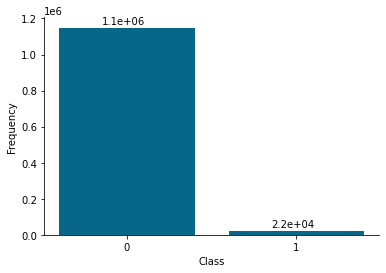

In [5]:
fig, ax = plt.subplots()
ax.bar(train['SepsisLabel'].value_counts().index,
       train['SepsisLabel'].value_counts())
ax.set_xticks([0,1])
ax.set_xlabel('Class')
# ax.set_title('Sepsis Label Distribution')
ax.set_ylabel('Frequency')
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20000))
plt.savefig(r"..\Figures\Label_dist.pdf")

### Check For null in Features/ Independent variables

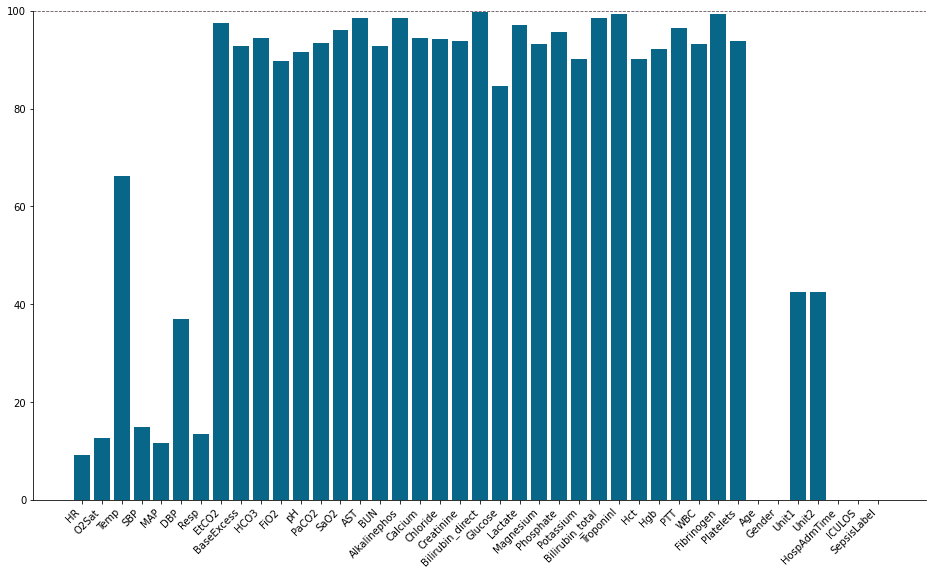

In [6]:
missing = (train.isnull().sum() / train.shape[0]) * 100

fig, ax = plt.subplots(figsize = (16, 9))

ax.bar(missing.index, missing)
ax.set_xticklabels(missing.index, rotation = 45, ha = 'right')
ax.set_ylim(bottom = 0, top = 100)

plt.axhline(y = 100, color = colorlist[2], linewidth = 0.8, linestyle = '--')
plt.savefig(r"..\Figures\var_missing_hist.pdf")

In [7]:
# Use only those variables that have at less than 90% missing values
selected_cols = list(missing[missing < 90].index)
filter_train = train[selected_cols]

### Univariate plots

In [8]:
categorical = filter_train.dtypes == object
categorical['Unit1'] = True
categorical['Unit2'] = True
categorical['Gender'] = True

cat_vars = list(categorical[categorical].index)
cont_vars = list(categorical[~categorical].index)

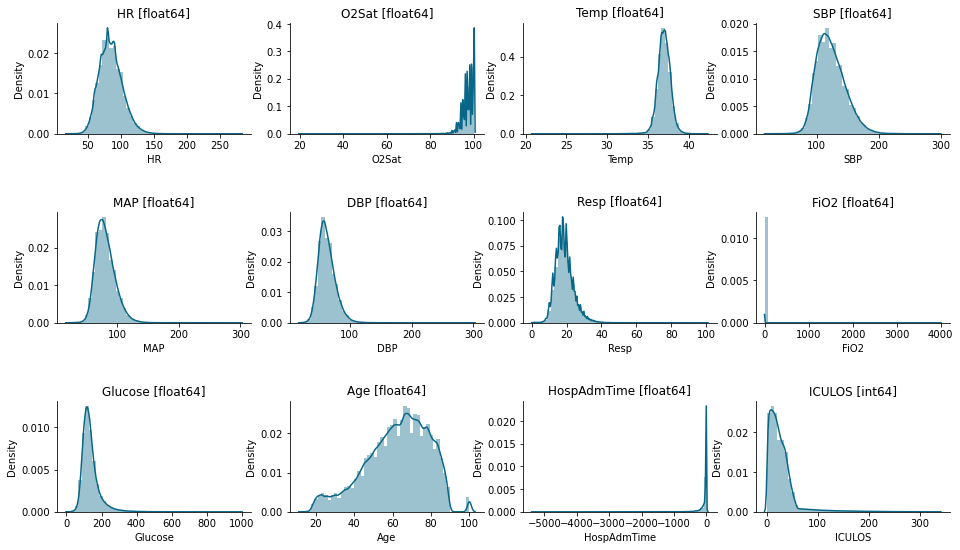

In [9]:
fig, ax = plt.subplots((len(cont_vars))//4, 4, figsize = (16, 9))
fig.subplots_adjust(hspace = 0.7)
for i, var in enumerate(cont_vars[:-1]):
    x, y = i//4, i%4
    var_type = filter_train[var].dtypes
    ax[x, y].set_title(f"{var} [{var_type}]")
    ax[x, y].set_xlabel(str(var))
    sns.distplot(filter_train[var].dropna(), ax = ax[x, y])
    
plt.savefig(r"..\Figures\var_dists.pdf")

### Label Distribution over Sub-groups

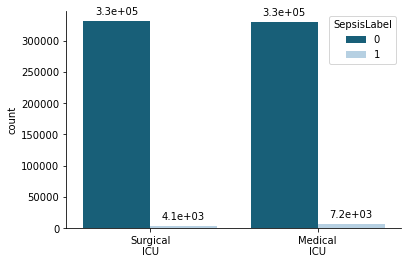

In [10]:
fig, ax = plt.subplots()
sns.countplot(filter_train['Unit1'].dropna(), hue='SepsisLabel', data = filter_train, ax = ax)
ax.set_xticklabels(["Surgical\nICU", "Medical\nICU"])
ax.set_xlabel("")
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.07, p.get_height() + 10000))
plt.savefig(r"..\Figures\label_ICU.pdf")

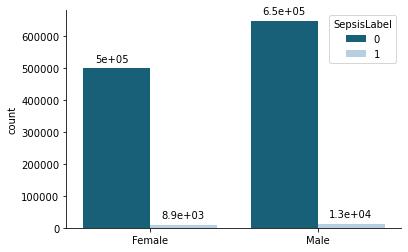

In [11]:
fig, ax = plt.subplots()
sns.countplot(filter_train['Gender'].dropna(), hue='SepsisLabel', data = filter_train, ax = ax)
ax.set_xticklabels(["Female", "Male"])
ax.set_xlabel("")
for p in ax.patches:
    ax.annotate('{:.2g}'.format(p.get_height()), (p.get_x() + 0.07, p.get_height() + 20000))
plt.savefig(r"..\Figures\label_per_sex.pdf")

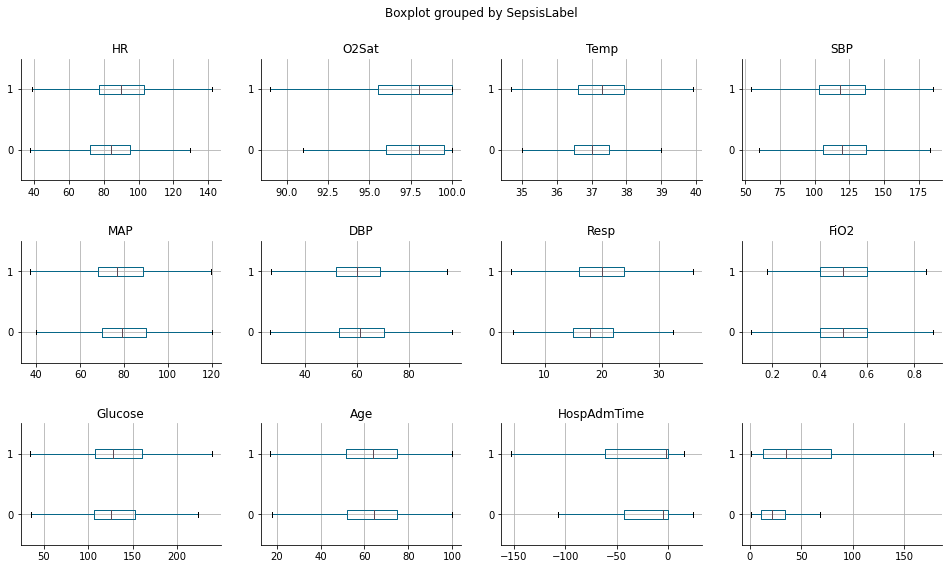

In [12]:
fig, ax = plt.subplots((len(cont_vars))//4, 4, figsize = (16, 9))
fig.subplots_adjust(hspace = 0.5)
for i, var in enumerate(cont_vars[:-1]):
    x, y = i//4, i%4
    filter_train.boxplot(var, by = 'SepsisLabel', ax = ax[x, y], vert = False, showfliers=False)
    ax[x, y].set_xlabel("")
    
plt.title("")
plt.savefig(r"..\Figures\box_per_var.pdf")

### Summarized Statistics for the Dataset

In [13]:
# Get a table with descriptives of the data
columns_OI = {
    'HR': "Heart Rate (bpm)", 'O2Sat': "Pulse oximetry (%)",
    'Temp': "Temperature (Celsius)", 'SBP': "Systolic blood pressure (mm Hg)",
    'MAP': "Mean arterial pressure (mm Hg)", 'DBP': "Diastolic blood pressure (mm Hg)",
    'Resp': "Respiration Rate (bpm)", 'FiO2': "Fraction of inspired oxygen (%)",
    'Glucose': "Serum glucose (mg/dL)", 'ICULOS': "ICU length-of-stay",
    'Unit1': "Type of ICU", 'Age': "Age", 'Gender': "Gender", 
    'HospAdmTime': "Hospital Admission Time"
    }

temp = train \
    .rename(columns = columns_OI) \
    [columns_OI.values()] \
    .describe() \
    .transpose()

temp['% missing'] = 1 - temp['count']/train.shape[0]

temp.to_latex(
    r"..\Tables\tab_describe_new.tex",
    columns = ['mean', 'std', 'min', '50%', 'max', '% missing'],
    header = ['Mean', 'Standard Deviation', 'Minimum', 'Median', 'Maximum', 'Percent Missing'],
    float_format = "%2.2f",
    column_format = "l" + "c"*6,
    caption = "Summary Statistics",
    label = "tab_describe"
)

### Correlation Plot for the Variables

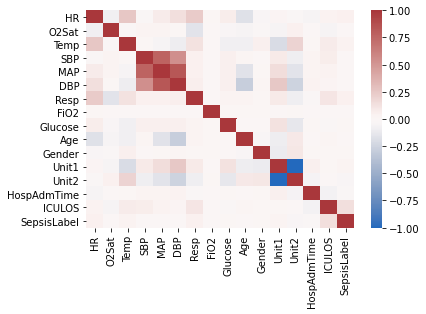

In [14]:
fig, ax = plt.subplots()
sns.heatmap(filter_train.corr(), ax = ax, cmap = sns.color_palette("vlag", as_cmap=True))
plt.savefig(r"..\Figures\corr_plot.pdf")

## Data Preparation

### Heart Rate

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing

In [15]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

### Temperature

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C.  Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing

In [16]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

    train['custom_temp'].fillna('Missing', inplace=True)
    return train

### Age

Categorizing patient based on age to old, infant and Child/adult

In [17]:
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <1, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
    return train

### O2Stat

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [18]:
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

    train['custom_o2stat'].fillna('Missing', inplace=True)
    return train

### SBP and DBP

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [19]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

    train['custom_bp'].fillna('Missing', inplace=True)
    return train

### Respiration Rate

Respiration rate for healthy adults is between 12 and 20.  Categorizing respiratory rate as normal and abnormal based on thresholds.

In [20]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'

    train['custom_resp'].fillna('Missing', inplace=True)
    
    return train

## Transform Train and Validation sets

In [23]:
for dtset in [train, val]:
    dtset = featuer_engineer_age(dtset)
    dtset = feature_engineer_blood_pressure(dtset)
    dtset = feature_engineer_hr(dtset)
    dtset = feature_engineer_o2stat(dtset)
    dtset = feature_engineer_temp(dtset)
    dtset = feature_engineer_resp_rate(dtset)

## Intution Based Feature Selection

According to the CDC website heart rate, fever and BP are the most important signs of sepsis. So selecting these features with the same intution

In [24]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [25]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

## Defining the Pipeline

In [26]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


## Custom Score function

In [27]:
def score_model(model, metric_list, y_true, y_pred):
    metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
    df = pd.DataFrame()
    df['model'] = [model]
    for metric in metric_list:
        df[metric] = [metric_dict[metric](y_true, y_pred)]
    return df

# Building the Model

## Training the Model

In [28]:
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier())

dt_model = dt_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

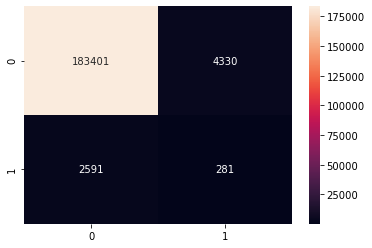

In [29]:
pred = dt_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [30]:
score_model('Decision_Tree', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Decision_Tree,0.097841,0.060941,0.019556


## Evaluate the Fairness of the Model